In [1]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install -q tensorflow==2.3

In [3]:
#аугментации изображений
!pip install albumentations -q

In [4]:
!pip install pymorphy2

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# https://pypi.org/project/keras-adabound/
!pip install keras-adabound

Defaulting to user installation because normal site-packages is not writeable


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

import nltk
nltk.download('stopwords')

from keras_adabound import AdaBound

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

[nltk_data] Downloading package stopwords to /home/yb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [9]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [10]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [11]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [12]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [14]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [15]:
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [16]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

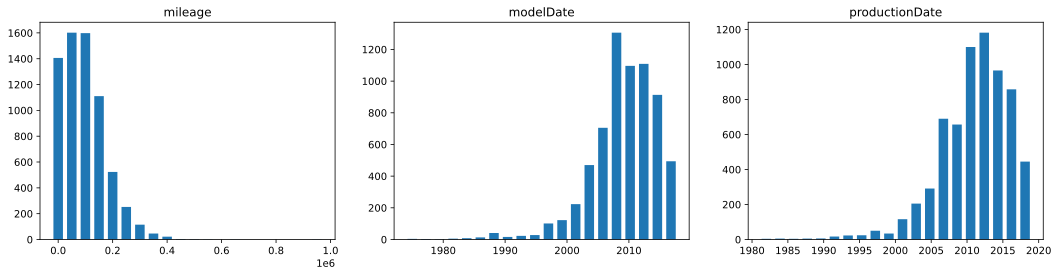

In [17]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

Итого:

    CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

# PreProc Tabular Data

In [18]:
#убираем признаки: 'name','Владельцы','ПТС'
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info',
  'numberOfDoors', 'vehicleTransmission', 'Привод', 'Руль']

#используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','Владение','enginePower','engineDisplacement']

In [19]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [20]:
data.isna().sum()

bodyType                   0
brand                      0
color                      0
description                0
engineDisplacement         0
enginePower                0
fuelType                   0
mileage                    0
modelDate                  0
model_info                 0
name                       0
numberOfDoors              0
productionDate             0
sell_id                    0
vehicleConfiguration       0
vehicleTransmission        0
Владельцы                  1
Владение                5418
ПТС                        0
Привод                     0
Руль                       0
sample                     0
price                      0
dtype: int64

In [21]:
data.sample(3)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
7399,внедорожник 5 дв.,BMW,коричневый,"Авто в одних руках,все обслуживание по реглам...",2.0 LTR,245 N12,бензин,107000,2014,X3,...,1091374938,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,4 года и 9 месяцев,Оригинал,полный,Левый,1,1590000.0
4273,внедорожник 5 дв.,BMW,чёрный,"Год выпуска 2016, приобрел новую без пробега в...",2.0 LTR,245 N12,гибрид,45000,2013,X5,...,1099098578,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,1 владелец,2 года и 6 месяцев,Оригинал,полный,Левый,1,3100000.0
3362,седан,MERCEDES,чёрный,В идеальном состоянии. Обслуживание в Панавто ...,5.5 LTR,585 N12,бензин,55000,2013,S_KLASSE_AMG,...,1094635516,SEDAN AUTOMATIC 5.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,1,3750000.0


In [22]:
data.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'modelDate', 'model_info', 'name',
       'numberOfDoors', 'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС', 'Привод', 'Руль',
       'sample', 'price'],
      dtype='object')

In [23]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id', 'name','Владельцы','ПТС'], axis = 1, inplace=True)
    
     # ################### Feature Engineering ####################################################
    #Владение
    def num_of_months(row):
        if pd.notnull(row):
            list_ownership = row.split()
            if len(list_ownership) == 2:
                if list_ownership[1] in ['год', 'года', 'лет']:
                    return int(list_ownership[0])*12
                return int(list_ownership[0])
            return int(list_ownership[0])*12 + int(list_ownership[3])
    df_output['Владение'] = df_output['Владение'].apply(num_of_months)
    
    # enginePower, оставим только цифру в enginePower
    df_output['enginePower'] = df_output['enginePower'].apply(lambda x: int(x.split()[0]))
    
     # engineDisplacement, оставим только цифру в engineDisplacement
    df_output['engineDisplacement'][df_output['engineDisplacement'] == 'undefined LTR'] = 'NaN'    
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(lambda x: float(x.split()[0]))
    
    
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)
        if column == 'modelDate':
            df_output['modelDate'] = np.log(2020 - data['modelDate'])
        else:
            df_output[column]=df_output[column].apply(lambda x: np.log(x))
    
    # Нормализация данных
    scaler = MinMaxScaler()
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    df_output = df_output.dropna() # !!! вернул на место
    
    return df_output

In [24]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

<ipython-input-23-5d61dd4c48b9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output['engineDisplacement'][df_output['engineDisplacement'] == 'undefined LTR'] = 'NaN'


,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,sample,price,bodyType_0,bodyType_1,...,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
3640,0.467888,0.439126,0.891384,0.638495,0.686257,0.840323,1,630000.0,0,0,...,1,0,0,0,1,0,0,1,1,0
6421,0.467888,0.310328,0.866257,0.616137,0.791046,0.619468,1,680000.0,0,1,...,1,1,0,0,0,1,0,0,1,0
7645,0.420931,0.339223,0.829621,0.659062,0.712474,0.619468,1,599000.0,0,0,...,0,0,1,0,0,0,1,0,1,0
7222,0.467888,0.529985,0.757345,0.413544,0.895627,0.619468,1,2150000.0,0,1,...,1,1,0,0,0,0,0,1,1,0
4604,0.648598,0.553132,0.852324,0.616137,0.791046,0.619468,1,1290000.0,0,0,...,0,1,0,0,0,0,0,1,1,0
5140,0.275896,0.310328,0.673618,0.178104,0.973926,0.619468,1,1898000.0,0,0,...,1,0,0,0,1,0,1,0,1,0
728,0.420931,0.339223,0.866900,0.659062,0.764868,0.354121,0,0.0,0,0,...,0,0,1,0,0,0,1,0,1,0
7029,0.567340,0.477709,0.830379,0.742679,0.633785,0.449422,1,675000.0,0,0,...,0,1,0,0,0,1,0,0,1,0
1997,0.648598,0.629523,0.893054,0.659062,0.712474,0.619468,1,970000.0,0,1,...,1,1,0,0,0,0,0,1,1,0
3433,0.467888,0.463097,0.867353,0.564575,0.791046,0.619468,1,890000.0,0,0,...,1,0,0,0,1,0,0,1,1,0


In [25]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8353 entries, 0 to 8352
Columns: 183 entries, engineDisplacement to Руль_1
dtypes: float64(7), int64(1), uint8(175)
memory usage: 2.0 MB


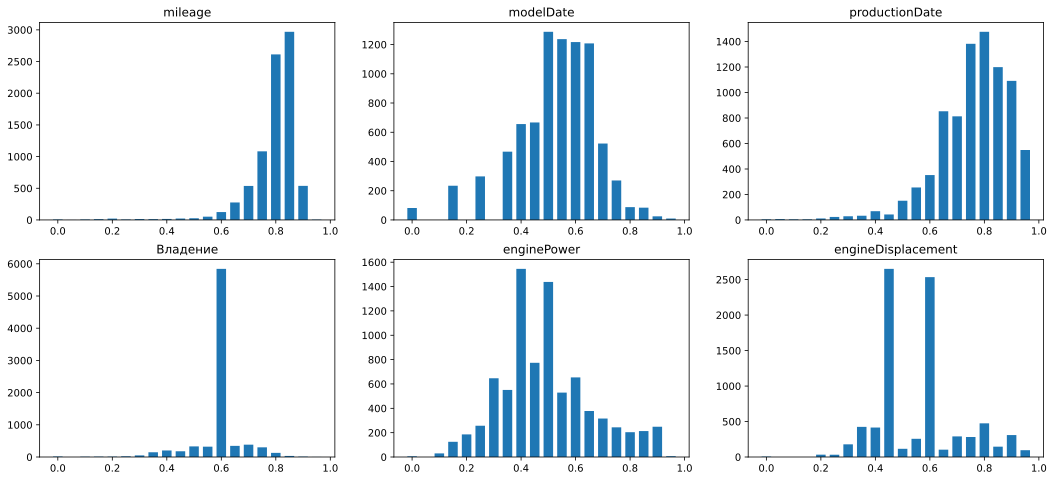

In [26]:
visualize_distributions({
    'mileage': df_preproc['mileage'].dropna(),
    'modelDate': df_preproc['modelDate'].dropna(),
    'productionDate': df_preproc['productionDate'].dropna(),
    'Владение': df_preproc['Владение'].dropna(),
    'enginePower': df_preproc['enginePower'].dropna(),
    'engineDisplacement': df_preproc['engineDisplacement'].dropna()
})

## Split data

In [27]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [28]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 182 entries, engineDisplacement to Руль_1
dtypes: float64(7), uint8(175)
memory usage: 390.0 KB


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

# Model 2: CatBoostRegressor

In [30]:
# model = CatBoostRegressor(iterations = 5000,
#                           #depth=10,
#                           #learning_rate = 0.5,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['RMSE', 'MAE'],
#                           od_wait=500,
#                           #task_type='GPU',
#                          )
# model.fit(X_train, y_train,
#          eval_set=(X_test, y_test),
#          verbose_eval=100,
#          use_best_model=True,
#          #plot=True
#          )

In [31]:
# test_predict_catboost = model.predict(X_test)
# print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

In [32]:
# sub_predict_catboost = model.predict(X_sub)
# sample_submission['price'] = sub_predict_catboost
# sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x//1000)*1000)
# sample_submission.to_csv('catboost_submission.csv', index=False)

In [33]:
# sample_submission.head()

# Model 3: Tabular NN

Построим обычную сеть:


In [34]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,productionDate,Владение,bodyType_0,bodyType_1,bodyType_2,bodyType_3,...,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.957522,0.887119,0.862682,0.638495,0.764868,0.803543,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
8037,0.467888,0.529985,0.720170,0.356207,0.947839,0.619468,0,1,0,0,...,1,1,0,0,0,0,0,1,1,0
4681,0.663211,0.547896,0.854462,0.712414,0.633785,0.619468,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
6014,0.420931,0.401796,0.919752,0.678104,0.660028,0.744101,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
3649,0.648598,0.639649,0.850062,0.564575,0.817211,0.741931,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0


## Simple Dense NN

In [35]:
model = Sequential()
model.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(512, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              186368    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 711,681
Trainable params: 711,681
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [38]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [39]:
# history = model.fit(X_train, y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=(X_test, y_test),
#                     callbacks=callbacks_list,
#                     verbose=0,
#                    )

In [40]:
# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

In [41]:
# model.load_weights('best_model.hdf5')
# model.save('nn_1.hdf5')

In [42]:
# test_predict_nn1 = model.predict(X_test)
# print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

In [43]:
# sub_predict_nn1 = model.predict(X_sub)
# sample_submission['price'] = sub_predict_nn1[:,0]
# sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x//1000)*1000)
# sample_submission.to_csv('nn1_submission.csv', index=False)

In [44]:
# sample_submission.head()

# Model 4: NLP + Multiple Inputs

In [45]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

* Избавимся от букв латинского алфавита, чисел, знаков препинания и всех символов;
* разобьем пост на токены;
* проведем лемматизацияю, получив нормальную (начальную) форму слова;
* удалим стоп-слова.

In [46]:
from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords

In [47]:
patterns = r"[A-Za-z0-9^\W]+"
stopwords_ru = stopwords.words("russian")
morph = MorphAnalyzer()
def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        if token and token not in stopwords_ru:
            token = token.strip()
            token = morph.normal_forms(token)[0]
            
            tokens.append(token)
    return tokens

In [48]:
%%time
data.description = data.description.apply(lemmatize)

CPU times: user 1min 7s, sys: 36.5 ms, total: 1min 7s
Wall time: 1min 7s


In [49]:
data.description

0       [весь, привет, продать, эксклюзивный, проект, ...
1       [продавать, любимый, тачил, обвес, тюнинг, пот...
2       [машина, продаваться, первый, но, только, пере...
3       [автомобиль, отличный, состояние, весь, родный...
4       [немка, бесключивый, доступ, камера, задний, в...
                              ...                        
8348    [продаваться, любимый, автомобиль, за, год, эк...
8349    [купить, официальный, дилер, г, третий, владел...
8350    [торг, место, всё, работать, сборка, немецкий,...
8351    [автомобиль, отличный, состояние, авто, семья,...
8352    [удлинённый, заводский, база, вообще, правильн...
Name: description, Length: 8353, dtype: object

Посмотрим самые распространенные слова в описании

In [50]:
from collections import defaultdict

In [51]:
word_freq = defaultdict(int)
for tokens in data.description.dropna():
    for token in tokens:
        word_freq[token] += 1

In [52]:
len(word_freq)

13617

In [53]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['автомобиль',
 'система',
 'пробег',
 'задний',
 'салон',
 'сидение',
 'год',
 'состояние',
 'передний',
 'машина']

In [54]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [55]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [56]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 276 ms, sys: 1e+03 ns, total: 276 ms
Wall time: 276 ms


In [57]:
#tokenize.word_index

In [58]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 220 ms, sys: 8 ms, total: 228 ms
Wall time: 228 ms


In [59]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

['автомобиль', 'проверить', 'пункт', 'автокредит', 'специальный', 'ставка', 'ауди', 'центр', 'север', 'официальный', 'дилер', 'входящий', 'группа', 'компания', 'рольф', 'являться', 'один', 'крупный', 'дилер', 'европа', 'предлагать', 'вы', 'ряд', 'услуга', 'покупка', 'продажа', 'автомобиль', 'пробег', 'на', 'протяжение', 'многий', 'год', 'наш', 'дилерский', 'центр', 'являться', 'лидер', 'продажа', 'автомобиль', 'пробег', 'среди', 'дилер', 'россия', 'предоставлять', 'клиент', 'самый', 'большой', 'выбор', 'автомобиль', 'пробег', 'другой', 'марка', 'каждый', 'автомобиль', 'проходить', 'тщательный', 'диагностик', 'подготовка', 'гарантировать', 'находиться', 'отличный', 'состояние', 'чтобы', 'убедиться', 'правильный', 'выбор', 'вы', 'возможность', 'пройти', 'тест', 'драйв', 'ознакомительный', 'поездка', 'интересовать', 'автомобиль', 'вы', 'смочь', 'ознакомиться', 'автомобиль', 'выходить', 'дом', 'наш', 'менеджер', 'провести', 'презентация', 'видеозвонок', 'показать', 'выбрать', 'автомобиль',

### RNN NLP

In [60]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [61]:
# сюда вставлять лучшие параметры из модель 3.

In [62]:
model_mlp = Sequential()
model_mlp.add(L.Dense(1024, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(512, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [63]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [64]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     3486208     seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [65]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [66]:
checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [67]:
# %%time
# history = model.fit([text_train_sequences, X_train], y_train,
#                     batch_size=512,
#                     epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
#                     validation_data=([text_test_sequences, X_test], y_test),
#                     callbacks=callbacks_list
#                    )

In [68]:
# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

In [69]:
# model.load_weights('best_model.hdf5')
# model.save('nn_mlp_nlp.hdf5')

In [70]:
# test_predict_nn2 = model.predict([text_test_sequences, X_test])
# print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

In [71]:
# sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
# sample_submission['price'] = sub_predict_nn2[:,0]
# sample_submission['price'] = sample_submission['price'].apply(lambda x: round(x//1000)*1000)
# sample_submission.to_csv('nn2_submission.csv', index=False)

In [72]:
# sample_submission.head()



Идеи для улучшения NLP части:

     Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
     Сделать предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
     Поработать над алгоритмами очистки и аугментации текста



# Model 5: Добавляем картинки

### Data

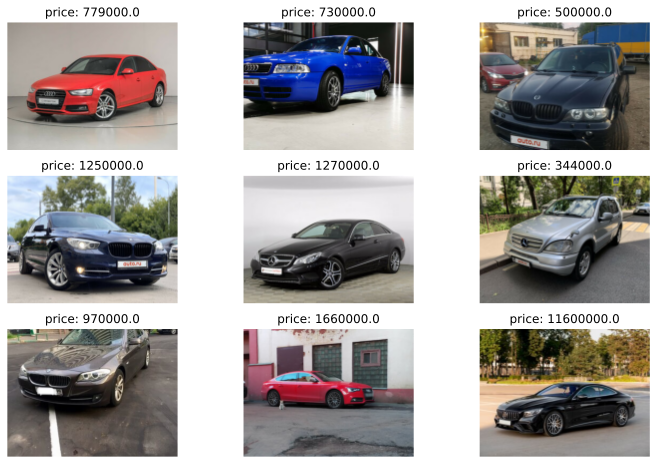

In [73]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [74]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


#### albumentations

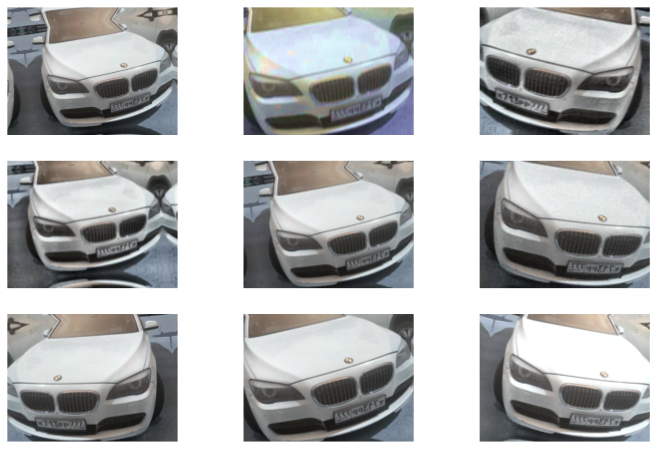

In [75]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [76]:
def make_augmentations(images):
    print('применение аугментаций', end = '')
    augmented_images = np.empty(images.shape)
    for i in range(images.shape[0]):
        if i % 200 == 0:
            print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
    print('')
    return augmented_images

In [77]:
# data.description

0       [весь, привет, продать, эксклюзивный, проект, ...
1       [продавать, любимый, тачил, обвес, тюнинг, пот...
2       [машина, продаваться, первый, но, только, пере...
3       [автомобиль, отличный, состояние, весь, родный...
4       [немка, бесключивый, доступ, камера, задний, в...
                              ...                        
8348    [продаваться, любимый, автомобиль, за, год, эк...
8349    [купить, официальный, дилер, г, третий, владел...
8350    [торг, место, всё, работать, сборка, немецкий,...
8351    [автомобиль, отличный, состояние, авто, семья,...
8352    [удлинённый, заводский, база, вообще, правильн...
Name: description, Length: 8353, dtype: object

In [78]:
# def tokenize_(x):
#     ret = sequence.pad_sequences(tokenize.texts_to_sequences(x), maxlen = MAX_SEQUENCE_LENGTH)
# #     print("ret", re)
#     return ret
    
# data['description2'] = data.description.apply(lambda x: tokenize_(x))
# data['description2'].iloc[0]

# data['description2'] = data.description.apply(lambda x: tf.keras.preprocessing.text.Tokenizer(np.asarray(x)))

array([[   0,    0,    0, ...,    0,    0,   92],
       [   0,    0,    0, ...,    0,    0, 2806],
       [   0,    0,    0, ...,    0,    0,  244],
       ...,
       [   0,    0,    0, ...,    0,    0,  133],
       [   0,    0,    0, ...,    0,    0,  643],
       [   0,    0,    0, ...,    0,    0,  218]], dtype=int32)

In [205]:
# data['description2'].iloc[0]


In [79]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

# def tokenize_(descriptions):
#     return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
#     print('text', text[0])
#     return text[0]
    return text
#     return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
#     print('there')
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    print(text)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
#     text = tf.convert_to_tensor(text, dtype=tf.string)
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

# text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
# text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
# text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MA

train_dataset = tf.data.Dataset.from_tensor_slices((
#     images_train, X_train, data.description.iloc[X_train.index], y_train
#     images_train, X_train, data['description2'].iloc[X_train.index], y_train
    images_train, X_train, text_train_sequences, y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
#     images_test, X_test, data.description.iloc[X_test.index], y_test
#     images_test, X_test, data['description2'].iloc[X_test.index], y_test
    images_test, X_test, text_test_sequences, y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
#     images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
#     images_sub, X_sub, data['description2'].iloc[X_sub.index], y_sub
    images_sub, X_sub, text_sub_sequences, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

Tensor("args_2:0", shape=(256,), dtype=int32)


### Строим сверточную сеть для анализа изображений без "головы"

In [80]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [107]:
#строим нейросеть для анализа табличных данных
# tabular_model = Sequential([
#     L.Input(shape = X.shape[1]),
#     L.Dense(1024, activation = 'relu'),
#     L.Dropout(0.5),
#     L.Dense(512, activation = 'relu'),
#     L.Dropout(0.5),
#     ])
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [108]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [109]:
BATCH_SIZE = 16
EPOCHS = 500
PATIENCE = 10
CHECKPOINT_FILEPATH = 'best_model.hdf5'
MONITOR = 'val_MAPE'
LOSS = 'MAPE'
MODE = 'min'
LR = 1e-3
FINAL_LR = 0.1

#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

# optimizer = tf.keras.optimizers.Adam(0.005)
optimizer = tf.keras.optimizers.Adam(0.1)
# optimizer=AdaBound(lr=LR, final_lr=FINAL_LR)
model.compile(loss=LOSS,optimizer=optimizer, metrics=[LOSS])

checkpoint = ModelCheckpoint(CHECKPOINT_FILEPATH, monitor=[MONITOR], verbose=0, mode=MODE)
earlystop = EarlyStopping(monitor=MONITOR, patience=PATIENCE, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]


Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
______________________________________________________________________________________

In [110]:
history = model.fit(train_dataset.batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = test_dataset.batch(BATCH_SIZE),
                    callbacks=callbacks_list
                   )

Epoch 1/500
355/355 [==============================] - 1292s 4s/step - loss: 45.1125 - MAPE: 45.1125 - val_loss: 32.8365 - val_MAPE: 32.8365
Epoch 2/500
  4/355 [..............................] - ETA: 15:39 - loss: 38.7328 - MAPE: 38.7328

KeyboardInterrupt: 

In [ ]:
# plt.title('Loss')
# plt.plot(history.history['MAPE'], label='train')
# plt.plot(history.history['val_MAPE'], label='test')
# plt.show();

In [102]:
os.getcwd()

'/home/yb/skillfactory_rds_batmobile/notebooks'

In [106]:
model.load_weights('best_model.hdf5')
model.save('../working/n3_ad_bs16_vp16.6185.hdf5')
# model.save('../working/n3_ab_bs16_vp15.6639.hdf5')

In [ ]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

In [ ]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

In [ ]:
sample_submission.head()

In [219]:
# checkpoint = ModelCheckpoint('best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
# earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
# callbacks_list = [checkpoint, earlystop]

In [220]:
# history = model.fit(train_dataset.batch(30),
#                     epochs=100,
#                     validation_data = test_dataset.batch(30),
#                     callbacks=callbacks_list
#                    )

Epoch 1/100
190/190 [==============================] - 1281s 7s/step - loss: 53.1996 - MAPE: 53.1996 - val_loss: 145.1095 - val_MAPE: 145.1095
Epoch 2/100
190/190 [==============================] - 1256s 7s/step - loss: 35.5054 - MAPE: 35.5054 - val_loss: 30.4576 - val_MAPE: 30.4576
Epoch 3/100
190/190 [==============================] - 1286s 7s/step - loss: 27.1490 - MAPE: 27.1490 - val_loss: 21.8035 - val_MAPE: 21.8035
Epoch 4/100
190/190 [==============================] - 1316s 7s/step - loss: 21.0415 - MAPE: 21.0415 - val_loss: 18.3793 - val_MAPE: 18.3793
Epoch 5/100
190/190 [==============================] - 1285s 7s/step - loss: 18.8296 - MAPE: 18.8296 - val_loss: 17.8369 - val_MAPE: 17.8369
Epoch 6/100
190/190 [==============================] - 1239s 7s/step - loss: 17.7802 - MAPE: 17.7802 - val_loss: 40.8811 - val_MAPE: 40.8811
Epoch 7/100
190/190 [==============================] - 1220s 6s/step - loss: 17.3599 - MAPE: 17.3599 - val_loss: 15.3883 - val_MAPE: 15.3883
Epoch 8/100

### Строим такую же нейросеть, только без картинок, чтобы сравнить результат с "картинками"

In [323]:
def tf_process_train_dataset_element2(table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (table_data, text), price

def tf_process_val_dataset_element2(table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (table_data, text), price

train_dataset2 = tf.data.Dataset.from_tensor_slices((
    X_train, text_train_sequences, y_train
    )).map(tf_process_train_dataset_element2)

test_dataset2 = tf.data.Dataset.from_tensor_slices((
    X_test, text_test_sequences, y_test
    )).map(tf_process_val_dataset_element2)

y_sub = np.zeros(len(X_sub))
sub_dataset2 = tf.data.Dataset.from_tensor_slices((
    X_sub, text_sub_sequences, y_sub
    )).map(tf_process_val_dataset_element2)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset2.__iter__().__next__();
test_dataset2.__iter__().__next__();
sub_dataset2.__iter__().__next__();

In [328]:
# BATCH_SIZE = 30 # попробовать 512
BATCH_SIZE = 512
EPOCHS = 500
PATIENCE = 10
CHECKPOINT_FILEPATH2 = 'best_model2.hdf5'
MONITOR = 'val_MAPE'
LOSS = 'MAPE'
MODE = 'min'
LR = 1e-3
FINAL_LR = 0.1

combinedInput2 = L.concatenate([tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput2)
head = L.Dense(1, activation="linear")(head)

model2 = Model(inputs=[tabular_model.input, nlp_model.input], outputs=head)
# optimizer = tf.keras.optimizers.Adam(0.005)
# optimizer2 = tf.keras.optimizers.Adam(0.01)

optimizer2=AdaBound(lr=LR, final_lr=FINAL_LR)
model2.compile(loss=LOSS,optimizer=optimizer2, metrics=[LOSS])

checkpoint2 = ModelCheckpoint(CHECKPOINT_FILEPATH2, monitor=[MONITOR], verbose=0, mode=MODE)
earlystop2 = EarlyStopping(monitor=MONITOR, patience=PATIENCE, restore_best_weights=True,)
callbacks_list2 = [checkpoint2, earlystop2]

In [330]:
history2 = model2.fit(train_dataset2.batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data = test_dataset2.batch(BATCH_SIZE),
                    callbacks=callbacks_list2
                   )

Epoch 1/100
12/12 [==============================] - 20s 2s/step - loss: 11.3933 - MAPE: 11.3933 - val_loss: 12.0709 - val_MAPE: 12.0709
Epoch 2/100
12/12 [==============================] - 21s 2s/step - loss: 11.4574 - MAPE: 11.4574 - val_loss: 12.0756 - val_MAPE: 12.0756
Epoch 3/100
12/12 [==============================] - 22s 2s/step - loss: 11.4122 - MAPE: 11.4122 - val_loss: 12.0833 - val_MAPE: 12.0833
Epoch 4/100
12/12 [==============================] - 21s 2s/step - loss: 11.4051 - MAPE: 11.4051 - val_loss: 12.0896 - val_MAPE: 12.0896
Epoch 5/100
12/12 [==============================] - 21s 2s/step - loss: 11.5720 - MAPE: 11.5720 - val_loss: 12.0909 - val_MAPE: 12.0909
Epoch 6/100
12/12 [==============================] - 22s 2s/step - loss: 11.3523 - MAPE: 11.3523 - val_loss: 12.0572 - val_MAPE: 12.0572
Epoch 7/100
12/12 [==============================] - 21s 2s/step - loss: 11.4780 - MAPE: 11.4780 - val_loss: 12.0481 - val_MAPE: 12.0481
Epoch 8/100
12/12 [======================

In [331]:
model2.load_weights(CHECKPOINT_FILEPATH2)
test_predict_nn2 = model2.predict(test_dataset2.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.08%


In [332]:
sub_predict_nn2 = model2.predict(sub_dataset2.batch(30))
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Blend

In [ ]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

In [ ]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission.csv', index=False)

In [ ]:
sample_submission.head()